这里主要是对实验中的数据进行线性拟合，获取拟合数据从而导入神经网络模型中。

需要注意的是：
- 用于拟合的实验数据需要保证单调变化，如果数据中存在两个相等的数据或者出现上下波动会影响拟合的结果（但如果运行未出错就不需要管）
- 文件需要分别将上升段和下降段分别保存，上升段保存为“your_name-GP.txt”，下降段保存为“your_name-GD.txt”，`your_name`自行设置名称用于区分即可，**建议使用英文**
- 为了保证文件结构的整洁，用于拟合的权重数据请放置在`data`文件夹中

这里使用的拟合方程如下：

$$GP_+ = GP_- + \alpha_P \cdot exp({-\beta_P \cdot \frac{GP_- - GP_{min}}{GP_{max}-GP_{min}}})$$

$$GD_+ = GD_- + \alpha_D \cdot exp({-\beta_D \cdot \frac{GD_{max} - GD_-}{GD_{max}-GD_{min}}})$$

其中，$\beta$为非线性度，数值越大曲线越弯；$\alpha$相当于步长（系数），即相邻两个数据点之间的差值程度

In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import os
# 读取文件数据
def read_G():
    filepath= './data/'

    GD = []
    GP = []

    f_P = open(f"{filepath}GP.txt", 'r')
    f_D = open(f"{filepath}GD.txt", 'r')
    for each_P in f_P:
        GP.append(float(each_P.replace('\n', '')))
    for each_D in f_D:
        GD.append(float(each_D.replace('\n', '')))
    
    return abs(np.array(GP)), abs(np.array(GD))
# 进行拟合
def my_fit(save=False):
    
    GP_ori, GD_ori = read_G()

    # 归一化方法1：
    # GP_nor = GP_ori/max(GP_ori)
    # GD_nor = GD_ori/max(GD_ori)

    # 归一化方法2：
    # GP_nor = (GP_ori-min(GP_ori))/(max(GP_ori)-min(GP_ori))
    # GD_nor = (GD_ori-min(GD_ori))/(max(GD_ori)-min(GD_ori))

    # 归一化方法3：
    GP_nor = (GP_ori-min(GP_ori))/(max(GP_ori)-min(GP_ori))
    GD_nor = (GD_ori-min(GD_ori))/(max(GD_ori)-min(GD_ori))

    P = np.arange(1, int(len(GP_ori)), 1)
    D = np.arange(1, int(len(GD_ori)), 1)

    GPmax = max(GP_nor)
    GPmin = min(GP_nor)
    GDmax = max(GD_nor)
    GDmin = min(GD_nor)
    xP = GP_nor[:-1]
    yP = GP_nor[1:]
    xD = GD_nor[:-1]
    yD = GD_nor[1:]

    print(f'GP-max:{GPmax}, GP-min:{GPmin}')
    print(f'GD-max:{GDmax}, GD-min:{GDmin}')

    # 电导拟合公式 其中aP，aD为拟合参数，bP与bD为非线性度
    def delt_GP(xP, bP, aP):
        yP = xP + aP * np.exp(-bP * ((xP - GPmin) / (GPmax - GPmin)))
        return yP
    def delt_GD(xD, bD, aD):
        yD = xD + aD * np.exp(-bD * ((GDmax - xD) / (GDmax - GDmin)))
        return yD

    # 电导数据拟合
    np.random.seed(0)
    def curve_fit_GP(P, xP, yP, save=False, save_name='-GP'):
        # yP 段拟合数据
        while True:
            err_stdev = 0 # 0.2
            yP_noise = err_stdev * np.random.normal(size=yP.size)
            yP_data = yP + yP_noise
            popt, pcov = curve_fit(delt_GP, xP, yP_data)#训练函数
            bP = popt[0]
            aP = popt[1]
            if bP < 0:
                continue
            else:
                break
        yPvals=delt_GP(xP, bP, aP)
        plt.plot(P, yP, '*',label='original values')
        plt.plot(P, yPvals, 'r',label='curve_fit values')
        # plt.ylim(0, 1)
        plt.xlabel('P axis')
        plt.ylabel('GP axis')
        plt.legend(loc=4)
        plt.title(f"curve_fit aP = %0.2f, bP = %0.2f" %(aP, bP))
        if save:
            plt.savefig(save_name + '.png', dpi=720)
            np.savetxt(save_name + '.txt', yPvals)
            print("GP-拟合图象与拟合数据已保存！")
        plt.show()
        return yPvals, GPmax
    def curve_fit_GD(D, xD, yD, your_name, save=False, save_name='-GD'):
        # yD 段拟合数据
        # while True:
        err_stdev = 0 # 0.2
        yD_noise = err_stdev * np.random.normal(size=xD.size)
        yD_data = yD + yD_noise
        popt, pcov = curve_fit(delt_GD, xD, yD_data)#训练函数
        bD = popt[0]
        aD = popt[1]
            # if bD < 0:
            #     continue
            # else:
            #     break
        yDvals=delt_GD(xD, bD, aD)
        plt.plot(D, yD, '*',label='original values')
        plt.plot(D, yDvals, 'r',label='curve_fit values')
        # plt.ylim(0,1)
        plt.xlabel('D axis')
        plt.ylabel('GD axis')
        plt.legend(loc=3)
        plt.title(f"curve_fit aD = %0.2f, bD = %0.2f" %(aD, bD))
        if save:
            plt.savefig(save_name + '.png', dpi=720)
            np.savetxt(save_name + '.txt', yDvals)
            print("GD-拟合图象与拟合数据已保存！")
        plt.show()
        return yDvals, GDmax


    if save:
        np.savetxt(f"GP_nor.txt", GP_nor)
        np.savetxt(f"GD_nor.txt", GD_nor)
        print("归一化电导数据已保存！")

    yPvals, yP = curve_fit_GP(P, xP, yP, save)
    yDvals, yD = curve_fit_GD(D, xD, yD, save)
    return yPvals, yP, yDvals, yD

# 主函数
def main(save):
    yPvals, yP, yDvals, yD = my_fit(save)
    print("请自行记录下图片中拟合参数的数值！")
    return yPvals, yP, yDvals, yD

运行下面单元格会跳出输入框，输入自己设置的名称即先前设置的`your_name`即可

运行完毕后会自动绘制拟合图像，对应的拟合参数会在图片上方写出，如图所示。

![](./img/%E6%8B%9F%E5%90%88%E8%84%9A%E6%9C%AC%E8%BF%90%E8%A1%8C.png)

注：`yP`与`yD`分别对应上升段和下降段的归一化数据，带有`vals`的为对应段的拟合数据，如有需要自行保存即可。

GP-max:1.0, GP-min:0.0
GD-max:1.0, GD-min:0.0


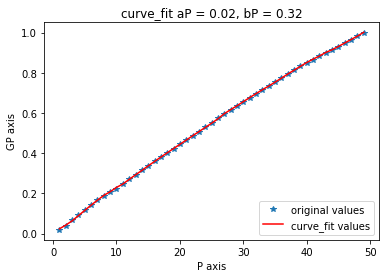

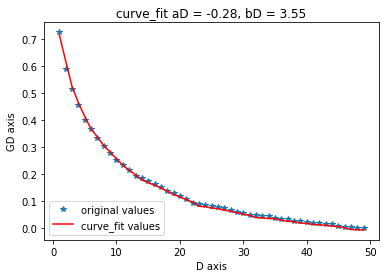

请自行记录下图片中拟合参数的数值！


In [6]:
yPvals, yP, yDvals, yD = main(save=False)
# print(yPvals)
# print(yDvals)